<a href="https://colab.research.google.com/gist/SK124/c01d6699011a27b660675526ca5f1eb5/molecular-fingerprint-mat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""" Imports neccesary for installing RDkit """
%cd /content 
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!cp '/content/drive/My Drive/Miniconda3-latest-Linux-x86_64.sh' /content/

!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/rdkit')
%cd /usr/local/lib/python3.7/site-packages/

/content
PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - \ | / - \ | / failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / - \ | / - \ | / - \ | / - failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | / - \ | / - \ 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed

UnsatisfiableError: The following specifications were found to be incompatible with each other:

Output in format: Requested package -> Available versions

Package xorg-libice conflicts for:
xorg-libsm -> xorg-libice=1.0
cairo -> xorg-libice
rdkit -> cairo[version='>=1.16.0,<1.17.0a0'] -> xorg-libice
cairo -> xorg-libsm -> xorg-libice=1.0
xorg-libice

In [ ]:
%cd /usr/local/lib/python3.7/site-packages/
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles

/usr/local/lib/python3.7/site-packages


In [ ]:
%cd /content
!git clone https://github.com/ardigen/MAT.git

/content
Cloning into 'MAT'...
remote: Enumerating objects: 101, done.
remote: Total 101 (delta 0), reused 0 (delta 0), pack-reused 101
Receiving objects: 100% (101/101), 414.45 KiB | 5.53 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:

import os
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles
#os.chdir('src')

In [ ]:
%cd /content/MAT
os.chdir('src')

/content/MAT


In [ ]:
from featurization.data_utils import load_data_from_df, construct_loader

In [ ]:
batch_size = 64

# Formal charges are one-hot encoded to keep compatibility with the pre-trained weights.
# If you do not plan to use the pre-trained weights, we recommend to set one_hot_formal_charge to False.
X, y = load_data_from_df('../data/freesolv/freesolv.csv', one_hot_formal_charge=True)
data_loader = construct_loader(X, y, batch_size)

In [ ]:
pd.read_csv('../data/freesolv/freesolv.csv').head()

,smiles,y
0,CN(C)C(=O)c1ccc(cc1)OC,-1.874467
1,CS(=O)(=O)Cl,-0.277514
2,CC(C)C=C,1.465089
3,CCc1cnccn1,-0.428367
4,CCCCCCCO,-0.105855


In [ ]:
df=pd.read_csv('../data/bbbp/bbbp.csv').head()

In [ ]:
df=df[:128]

In [ ]:
batch_size = 32

# Formal charges are one-hot encoded to keep compatibility with the pre-trained weights.
# If you do not plan to use the pre-trained weights, we recommend to set one_hot_formal_charge to False.
X, y = load_data_from_df('../data/freesolv/freesolv.csv', one_hot_formal_charge=True)
data_loader = construct_loader(X, y, batch_size)

In [ ]:
df.to_csv(r'/content/MAT/data/bbbp/bbbp128.csv', index = False)

In [ ]:
from transformer import make_model

In [ ]:
X[4][0].shape

(9, 28)

In [ ]:
d_atom = X[0][0].shape[1]
d_atom

28

In [ ]:
(X[641][0]).shape[1]

28

In [ ]:
en
import math, copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from utils import xavier_normal_small_init_, xavier_uniform_small_init_


### Model definition

def make_models(d_atom, N=2, d_model=128, h=8, dropout=0.1, 
               lambda_attention=0.3, lambda_distance=0.3, trainable_lambda=False,
               N_dense=2, leaky_relu_slope=0.0, aggregation_type='mean', 
               dense_output_nonlinearity='relu', distance_matrix_kernel='softmax',
               use_edge_features=False, n_output=1,
               control_edges=False, integrated_distances=False, 
               scale_norm=False, init_type='uniform', use_adapter=False, n_generator_layers=1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout, lambda_attention, lambda_distance, trainable_lambda, distance_matrix_kernel, use_edge_features, control_edges, integrated_distances)
    ff = PositionwiseFeedForward(d_model, N_dense, dropout, leaky_relu_slope, dense_output_nonlinearity)
    model = GraphTransformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout, scale_norm, use_adapter), N, scale_norm),
        Embeddings(d_model, d_atom, dropout))
       # Generator(d_model, aggregation_type, n_output, n_generator_layers, leaky_relu_slope, dropout, scale_norm))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            if init_type == 'uniform':
                nn.init.xavier_uniform_(p)
            elif init_type == 'normal':
                nn.init.xavier_normal_(p)
            elif init_type == 'small_normal_init':
                xavier_normal_small_init_(p)
            elif init_type == 'small_uniform_init':
                xavier_uniform_small_init_(p)
    return model


class GraphTransformer(nn.Module):
    def __init__(self, encoder, src_embed):
        super(GraphTransformer, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        
        
    def forward(self, src, src_mask, adj_matrix, distances_matrix, edges_att):
        "Take in and process masked src and target sequences."
        return self.encode(src, src_mask, adj_matrix, distances_matrix, edges_att)
    
    def encode(self, src, src_mask, adj_matrix, distances_matrix, edges_att):
        return self.encoder(self.src_embed(src), src_mask, adj_matrix, distances_matrix, edges_att)
    
    def predict(self, out, out_mask):
        return (out)
    
    
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, aggregation_type='mean', n_output=1, n_layers=1, 
                 leaky_relu_slope=0.01, dropout=0.0, scale_norm=False):
        super(Generator, self).__init__()
        if n_layers == 1:
            self.proj = nn.Linear(d_model, n_output)
        else:
            self.proj = []
            for i in range(n_layers-1):
                self.proj.append(nn.Linear(d_model, d_model))
                self.proj.append(nn.LeakyReLU(leaky_relu_slope))
                self.proj.append(ScaleNorm(d_model) if scale_norm else LayerNorm(d_model))
                self.proj.append(nn.Dropout(dropout))
            self.proj.append(nn.Linear(d_model, n_output))
            self.proj = torch.nn.Sequential(*self.proj)
        self.aggregation_type = aggregation_type

    def forward(self, x, mask):
        mask = mask.unsqueeze(-1).float()
        out_masked = x * mask
        if self.aggregation_type == 'mean':
            out_sum = out_masked.sum(dim=1)
            mask_sum = mask.sum(dim=(1))
            out_avg_pooling = out_sum / mask_sum
        elif self.aggregation_type == 'sum':
            out_sum = out_masked.sum(dim=1)
            out_avg_pooling = out_sum
        elif self.aggregation_type == 'dummy_node':
            out_avg_pooling = out_masked[:,0]
        projected = self.proj(out_avg_pooling)
        return projected
    
    
class PositionGenerator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model):
        super(PositionGenerator, self).__init__()
        self.norm = LayerNorm(d_model)
        self.proj = nn.Linear(d_model, 3)

    def forward(self, x, mask):
        mask = mask.unsqueeze(-1).float()
        out_masked = self.norm(x) * mask
        projected = self.proj(out_masked)
        return projected
    

### Encoder

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N, scale_norm):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = ScaleNorm(layer.size) if scale_norm else LayerNorm(layer.size)
        
    def forward(self, x, mask, adj_matrix, distances_matrix, edges_att):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask, adj_matrix, distances_matrix, edges_att)
        return self.norm(x)

    
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
    
class ScaleNorm(nn.Module):
    """ScaleNorm"""
    "All g’s in SCALE NORM are initialized to sqrt(d)"
    def __init__(self, scale, eps=1e-5):
        super(ScaleNorm, self).__init__()
        self.scale = nn.Parameter(torch.tensor(math.sqrt(scale)))
        self.eps = eps
        
    def forward(self, x):
        norm = self.scale / torch.norm(x, dim=-1, keepdim=True).clamp(min=self.eps)
        return x * norm

    
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout, scale_norm, use_adapter):
        super(SublayerConnection, self).__init__()
        self.norm = ScaleNorm(size) if scale_norm else LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        self.use_adapter = use_adapter
        self.adapter = Adapter(size, 8) if use_adapter else None

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        if self.use_adapter:
            return x + self.dropout(self.adapter(sublayer(self.norm(x))))
        return x + self.dropout(sublayer(self.norm(x)))

    
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout, scale_norm, use_adapter):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout, scale_norm, use_adapter), 2)
        self.size = size

    def forward(self, x, mask, adj_matrix, distances_matrix, edges_att):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, adj_matrix, distances_matrix, edges_att, mask))
        return self.sublayer[1](x, self.feed_forward)

    
### Attention           

class EdgeFeaturesLayer(nn.Module):
    def __init__(self, d_model, d_edge, h, dropout):
        super(EdgeFeaturesLayer, self).__init__()
        assert d_model % h == 0
        d_k = d_model // h
        self.linear = nn.Linear(d_edge, 1, bias=False)
        with torch.no_grad():
            self.linear.weight.fill_(0.25)

    def forward(self, x):
        p_edge = x.permute(0, 2, 3, 1)
        p_edge = self.linear(p_edge).permute(0, 3, 1, 2)
        return torch.relu(p_edge)
    

def attention(query, key, value, adj_matrix, distances_matrix, edges_att,
              mask=None, dropout=None, 
              lambdas=(0.3, 0.3, 0.4), trainable_lambda=False,
              distance_matrix_kernel=None, use_edge_features=False, control_edges=False,
              eps=1e-6, inf=1e12):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask.unsqueeze(1).repeat(1, query.shape[1], query.shape[2], 1) == 0, -inf)
    p_attn = F.softmax(scores, dim = -1)

    if use_edge_features:
        adj_matrix = edges_att.view(adj_matrix.shape)

    # Prepare adjacency matrix
    adj_matrix = adj_matrix / (adj_matrix.sum(dim=-1).unsqueeze(2) + eps)
    adj_matrix = adj_matrix.unsqueeze(1).repeat(1, query.shape[1], 1, 1)
    p_adj = adj_matrix
    
    p_dist = distances_matrix
    
    if trainable_lambda:
        softmax_attention, softmax_distance, softmax_adjacency = lambdas.cuda()
        p_weighted = softmax_attention * p_attn + softmax_distance * p_dist + softmax_adjacency * p_adj
    else:
        lambda_attention, lambda_distance, lambda_adjacency = lambdas
        p_weighted = lambda_attention * p_attn + lambda_distance * p_dist + lambda_adjacency * p_adj
    
    if dropout is not None:
        p_weighted = dropout(p_weighted)

    atoms_featrues = torch.matmul(p_weighted, value)     
    return atoms_featrues, p_weighted, p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1, lambda_attention=0.3, lambda_distance=0.3, trainable_lambda=False, 
                 distance_matrix_kernel='softmax', use_edge_features=False, control_edges=False, integrated_distances=False):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.trainable_lambda = trainable_lambda
        if trainable_lambda:
            lambda_adjacency = 1. - lambda_attention - lambda_distance
            lambdas_tensor = torch.tensor([lambda_attention, lambda_distance, lambda_adjacency], requires_grad=True)
            self.lambdas = torch.nn.Parameter(lambdas_tensor)
        else:
            lambda_adjacency = 1. - lambda_attention - lambda_distance
            self.lambdas = (lambda_attention, lambda_distance, lambda_adjacency)
            
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        if distance_matrix_kernel == 'softmax':
            self.distance_matrix_kernel = lambda x: F.softmax(-x, dim = -1)
        elif distance_matrix_kernel == 'exp':
            self.distance_matrix_kernel = lambda x: torch.exp(-x)
        self.integrated_distances = integrated_distances
        self.use_edge_features = use_edge_features
        self.control_edges = control_edges
        if use_edge_features:
            d_edge = 11 if not integrated_distances else 12
            self.edges_feature_layer = EdgeFeaturesLayer(d_model, d_edge, h, dropout)
        
    def forward(self, query, key, value, adj_matrix, distances_matrix, edges_att, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # Prepare distances matrix
        distances_matrix = distances_matrix.masked_fill(mask.repeat(1, mask.shape[-1], 1) == 0, np.inf)
        distances_matrix = self.distance_matrix_kernel(distances_matrix)
        p_dist = distances_matrix.unsqueeze(1).repeat(1, query.shape[1], 1, 1)

        if self.use_edge_features:
            if self.integrated_distances:
                edges_att = torch.cat((edges_att, distances_matrix.unsqueeze(1)), dim=1)
            edges_att = self.edges_feature_layer(edges_att)
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn, self.self_attn = attention(query, key, value, adj_matrix, 
                                                 p_dist, edges_att,
                                                 mask=mask, dropout=self.dropout,
                                                 lambdas=self.lambdas,
                                                 trainable_lambda=self.trainable_lambda,
                                                 distance_matrix_kernel=self.distance_matrix_kernel,
                                                 use_edge_features=self.use_edge_features,
                                                 control_edges=self.control_edges)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


### Conv 1x1 aka Positionwise feed forward

class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, N_dense, dropout=0.1, leaky_relu_slope=0.0, dense_output_nonlinearity='relu'):
        super(PositionwiseFeedForward, self).__init__()
        self.N_dense = N_dense
        self.linears = clones(nn.Linear(d_model, d_model), N_dense)
        self.dropout = clones(nn.Dropout(dropout), N_dense)
        self.leaky_relu_slope = leaky_relu_slope
        if dense_output_nonlinearity == 'relu':
            self.dense_output_nonlinearity = lambda x: F.leaky_relu(x, negative_slope=self.leaky_relu_slope)
        elif dense_output_nonlinearity == 'tanh':
            self.tanh = torch.nn.Tanh()
            self.dense_output_nonlinearity = lambda x: self.tanh(x)
        elif dense_output_nonlinearity == 'none':
            self.dense_output_nonlinearity = lambda x: x
            

    def forward(self, x):
        if self.N_dense == 0:
            return x
        
        for i in range(len(self.linears)-1):
            x = self.dropout[i](F.leaky_relu(self.linears[i](x), negative_slope=self.leaky_relu_slope))
            
        return self.dropout[-1](self.dense_output_nonlinearity(self.linears[-1](x)))

    
## Embeddings

class Embeddings(nn.Module):
    def __init__(self, d_model, d_atom, dropout):
        super(Embeddings, self).__init__()
        self.lut = nn.Linear(d_atom, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.lut(x))


In [ ]:
from en import make_models

In [ ]:

d_atom = X[0][0].shape[1]  # It depends on the used featurization.

model_params = {
    'd_atom': d_atom,
    'd_model': 1024,
    'N': 8,
    'h': 16,
    'N_dense': 1,
    'lambda_attention': 0.33, 
    'lambda_distance': 0.33,
    'leaky_relu_slope': 0.1, 
    'dense_output_nonlinearity': 'relu', 
    'distance_matrix_kernel': 'exp', 
    'dropout': 0.0,
    
}

model1 = make_models(**model_params)
model1

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.0, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SublayerConnection(
     

In [ ]:
model1

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.0, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SublayerConnection(
     

In [ ]:
from transform import make_model

In [ ]:
make_model

<function transformer.make_model>

In [ ]:

d_atom = X[0][0].shape[1]  # It depends on the used featurization.

model_params = {
    'd_atom': d_atom,
    'd_model': 1024,
    'N': 8,
    'h': 16,
    'N_dense': 1,
    'lambda_attention': 0.33, 
    'lambda_distance': 0.33,
    'leaky_relu_slope': 0.1, 
    'dense_output_nonlinearity': 'relu', 
    'distance_matrix_kernel': 'exp', 
    'dropout': 0.0,
    'aggregation_type': 'mean'
}

model = make_model(**model_params)
model

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.0, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SublayerConnection(
     

In [ ]:
model1

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.0, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SublayerConnection(
     

In [ ]:
cp '/content/drive/My Drive/De NovoDrug/pretrained_weights.pt' /content/MAT/src

In [ ]:
pretrained_name = 'pretrained_weights.pt'  # This file should be downloaded first (See README.md).
pretrained_state_dict = torch.load(pretrained_name)

In [ ]:
model_state_dict = model1.state_dict()
for name, param in pretrained_state_dict.items():
    if 'generator' in name:
         continue
    if isinstance(param, torch.nn.Parameter):
        param = param.data
    model_state_dict[name].copy_(param)

In [ ]:

for batch in data_loader:

    adjacency_matrix, node_features, distance_matrix, y = batch
    batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
    output = mode1l(node_features, batch_mask, adjacency_matrix, distance_matrix, None)


    
x=output
mask=batch_mask
mask = mask.unsqueeze(-1).float()
out_masked = x * mask
out_sum = x.sum(dim=1)
mask_sum = mask.sum(dim=(1))
out_avg_pooling = out_sum / mask_sum


In [ ]:
model_state_dict1 = model.state_dict()
for name, param in pretrained_state_dict.items():
    if 'generator' in name:
         continue
    if isinstance(param, torch.nn.Parameter):
        param = param.data
    model_state_dict[name].copy_(param)

In [ ]:

for batch in data_loader:

    adjacency_matrix, node_features, distance_matrix, y = batch
    batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
    output = mode1l(node_features, batch_mask, adjacency_matrix, distance_matrix, None)


    
x=output
mask=batch_mask
mask = mask.unsqueeze(-1).float()
out_masked = x * mask
out_sum = x.sum(dim=1)
mask_sum = mask.sum(dim=(1))
out_avg_pooling = out_sum / mask_sum


In [ ]:
model_state_dict1

OrderedDict([('encoder.layers.0.self_attn.linears.0.weight',
              tensor([[-0.0365,  0.0012, -0.0536,  ..., -0.0285,  0.0436, -0.0384],
                      [ 0.0431,  0.0158,  0.0229,  ..., -0.0279,  0.0492, -0.0053],
                      [-0.0359,  0.0122,  0.0405,  ..., -0.0511, -0.0131, -0.0218],
                      ...,
                      [ 0.0154,  0.0473,  0.0137,  ..., -0.0120,  0.0511, -0.0033],
                      [-0.0473, -0.0241,  0.0178,  ...,  0.0360,  0.0265,  0.0203],
                      [ 0.0168,  0.0155, -0.0262,  ..., -0.0123, -0.0207,  0.0021]])),
             ('encoder.layers.0.self_attn.linears.0.bias',
              tensor([ 0.0050,  0.0116, -0.0131,  ..., -0.0091,  0.0249,  0.0168])),
             ('encoder.layers.0.self_attn.linears.1.weight',
              tensor([[-0.0387, -0.0216,  0.0536,  ..., -0.0044, -0.0305, -0.0069],
                      [-0.0024, -0.0387, -0.0299,  ..., -0.0106, -0.0404, -0.0267],
                      [-0.0120, 

In [ ]:
model_state_dict

OrderedDict([('encoder.layers.0.self_attn.linears.0.weight',
              tensor([[ 0.0523,  0.0197, -0.0003,  ...,  0.0171,  0.0427, -0.0305],
                      [ 0.0014,  0.0492, -0.0425,  ...,  0.0028, -0.0104,  0.0015],
                      [ 0.0403,  0.0453,  0.0339,  ...,  0.0180, -0.0286, -0.0413],
                      ...,
                      [ 0.0378,  0.0147,  0.0352,  ...,  0.0411, -0.0403,  0.0409],
                      [ 0.0477,  0.0430,  0.0343,  ...,  0.0194,  0.0390, -0.0340],
                      [-0.0023, -0.0492, -0.0140,  ..., -0.0462,  0.0443, -0.0047]])),
             ('encoder.layers.0.self_attn.linears.0.bias',
              tensor([-0.0189,  0.0018,  0.0261,  ...,  0.0225, -0.0111, -0.0002])),
             ('encoder.layers.0.self_attn.linears.1.weight',
              tensor([[-0.0003, -0.0490, -0.0487,  ...,  0.0246,  0.0356, -0.0149],
                      [ 0.0270,  0.0260, -0.0352,  ...,  0.0345, -0.0443, -0.0432],
                      [-0.0615, 

In [ ]:

def tryi():
  model_state_dict = model1.state_dict()
  for name, param in pretrained_state_dict.items():
      
      if isinstance(param, torch.nn.Parameter):
          param = param.data
      model_state_dict[name].copy_(param)
      if 'generator' in name:
           return

In [ ]:
model_state_dict

OrderedDict([('encoder.layers.0.self_attn.linears.0.weight',
              tensor([[ 0.0523,  0.0197, -0.0003,  ...,  0.0171,  0.0427, -0.0305],
                      [ 0.0014,  0.0492, -0.0425,  ...,  0.0028, -0.0104,  0.0015],
                      [ 0.0403,  0.0453,  0.0339,  ...,  0.0180, -0.0286, -0.0413],
                      ...,
                      [ 0.0378,  0.0147,  0.0352,  ...,  0.0411, -0.0403,  0.0409],
                      [ 0.0477,  0.0430,  0.0343,  ...,  0.0194,  0.0390, -0.0340],
                      [-0.0023, -0.0492, -0.0140,  ..., -0.0462,  0.0443, -0.0047]])),
             ('encoder.layers.0.self_attn.linears.0.bias',
              tensor([-0.0189,  0.0018,  0.0261,  ...,  0.0225, -0.0111, -0.0002])),
             ('encoder.layers.0.self_attn.linears.1.weight',
              tensor([[-0.0003, -0.0490, -0.0487,  ...,  0.0246,  0.0356, -0.0149],
                      [ 0.0270,  0.0260, -0.0352,  ...,  0.0345, -0.0443, -0.0432],
                      [-0.0615, 

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt

In [ ]:
opt = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.MSELoss()

In [ ]:
batch_size = 32

# Formal charges are one-hot encoded to keep compatibility with the pre-trained weights.
# If you do not plan to use the pre-trained weights, we recommend to set one_hot_formal_charge to False.
X, y = load_data_from_df('../data/freesolv/freesolv.csv', one_hot_formal_charge=True)
data_loader = construct_loader(X, y, batch_size)

In [ ]:
def train_epoch(model, opt, criterion):
    #model.cuda()
    model.train()
    losses = []
    for batch in data_loader:
        adjacency_matrix, node_features, distance_matrix, y = batch
        batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
        opt.zero_grad()
        output = model(node_features, batch_mask, adjacency_matrix, distance_matrix, None)
        loss = criterion(output, y)
        loss.backward()
        losses.append(loss.data.numpy())
        opt.step()        
        losses.append(loss.data.numpy())
    return losses


       

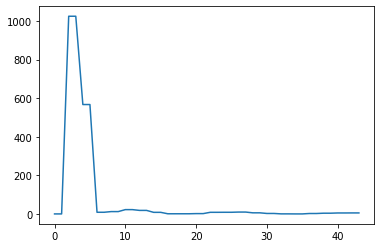

In [ ]:
e_losses = []
num_epochs = 2
for e in range(num_epochs):
    e_losses += train_epoch(model, opt, criterion)
plt.plot(e_losses)

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!nvidia-smi

Mon Aug 24 08:36:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    57W / 149W |    389MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model.cuda()
for batch in data_loader:
    adjacency_matrix, node_features, distance_matrix, y = batch
    batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
    output = model(node_features, batch_mask, adjacency_matrix, distance_matrix, None)
    out.append(output)


In [ ]:
for batch in data_loader:

    adjacency_matrix, node_features, distance_matrix, y = batch
    batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
    output = model1(node_features, batch_mask, adjacency_matrix, distance_matrix, None)

In [ ]:

for batch in data_loader:

    adjacency_matrix, node_features, distance_matrix, y = batch
    batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
    output = model(node_features, batch_mask, adjacency_matrix, distance_matrix, None)


    
x=output
mask=batch_mask
mask = mask.unsqueeze(-1).float()
out_masked = x * mask
out_sum = x.sum(dim=1)
mask_sum = mask.sum(dim=(1))
out_avg_pooling = out_sum / mask_sum


In [ ]:
x=output
mask=batch_mask
mask = mask.unsqueeze(-1).float()
out_masked = x * mask
out_sum = x.sum(dim=1)
mask_sum = mask.sum(dim=(1))
out_avg_pooling = out_sum / mask_sum


In [ ]:
batch_mask.shape

torch.Size([2, 10])

In [ ]:
output

torch.Size([2, 10, 1024])

In [ ]:
output.shape

torch.Size([2, 10, 1024])

In [ ]:
out_sum.shape

torch.Size([10])

In [ ]:
mask_sum.shape
mask_sum

tensor([24, 21, 27, 30, 22])

In [ ]:
len(batch)

4

In [ ]:
output

tensor([[[-1.3529, -0.3415,  1.4923,  ..., -1.0154, -0.6525,  2.0210],
         [-0.6542, -0.8702,  0.1097,  ..., -0.9197, -0.7331,  2.4551],
         [-0.5797, -1.1829, -0.0424,  ..., -0.8563, -0.4092,  2.2854],
         ...,
         [-0.2007, -0.8522, -0.3655,  ..., -0.4852, -0.1806,  1.4063],
         [-0.2007, -0.8522, -0.3655,  ..., -0.4852, -0.1806,  1.4063],
         [-0.2007, -0.8522, -0.3655,  ..., -0.4852, -0.1806,  1.4063]],

        [[-0.8367,  0.1325,  1.3578,  ..., -0.6594, -0.8688,  1.5665],
         [-0.2754, -1.1232, -0.0911,  ..., -0.9485, -1.5469,  2.0030],
         [-0.3617, -1.2107, -0.0183,  ..., -0.8000, -1.4827,  2.1218],
         ...,
         [ 0.0589, -0.4579,  0.0137,  ..., -0.7118, -1.5851,  1.5854],
         [ 0.0589, -0.4579,  0.0137,  ..., -0.7118, -1.5851,  1.5854],
         [ 0.0589, -0.4579,  0.0137,  ..., -0.7118, -1.5851,  1.5854]]],
       grad_fn=<AddBackward0>)

In [ ]:
out_sum = out_masked.sum(dim=1)
mask_sum = mask.sum(dim=(1))
out_avg_pooling = out_sum / mask_sum

In [ ]:
output.shape

torch.Size([2, 10, 1024])

In [ ]:
x.shape

torch.Size([10, 1024])

In [ ]:
mask=output[1]
mask.shape

torch.Size([10, 1024])

In [ ]:
x=output[0]
mask=output[1]
out_masked=x*mask

In [ ]:
mask=mask.unsqueeze(-1).float()

In [ ]:
mask.shape

torch.Size([10, 1024, 1])

In [ ]:
x=mask.unsqueeze(-1).float()

In [ ]:
x=output
mask=batch_mask
#x=x.unsqueeze(-1).float()
mask = mask.unsqueeze(-1).float()
out_masked = x * mask
out_sum = x.sum(dim=1)
mask_sum = mask.sum(dim=(1))
out_avg_pooling = out_sum / mask_sum


In [ ]:
out_avg_pooling.shape

torch.Size([2, 1024])

In [ ]:
out_masked.shape

torch.Size([2, 10, 1024])

In [ ]:
out_avg_pooling.shape

torch.Size([10, 10])

In [ ]:
x=output[0]
x=x.unsqueeze(-1).float()
x.shape

torch.Size([10, 1024, 1])

In [ ]:
output[1]

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  Tru

In [ ]:
output

(tensor([[[-1.2634,  0.2185,  1.2897,  ..., -1.0203, -0.3655,  1.5253],
          [-0.2849, -1.0072, -0.4562,  ..., -0.7751, -0.8033,  1.0816],
          [-0.3914, -0.4924, -0.2626,  ..., -0.7474, -1.0696,  0.7292],
          ...,
          [ 0.2695, -1.5059, -0.9538,  ..., -0.4632, -0.4351,  0.4090],
          [ 0.2695, -1.5059, -0.9538,  ..., -0.4632, -0.4351,  0.4090],
          [ 0.2695, -1.5059, -0.9538,  ..., -0.4632, -0.4351,  0.4090]],
 
         [[-1.2035,  0.2484,  1.5921,  ..., -0.7152, -0.6572,  1.2235],
          [ 0.2839, -0.6649, -0.6582,  ..., -0.9721, -0.7759,  0.7158],
          [-0.1604, -0.6607, -0.4911,  ..., -1.0997, -0.6646,  2.1016],
          ...,
          [ 0.2699, -1.5854, -1.0415,  ..., -0.8561, -0.5074,  0.4132],
          [ 0.2699, -1.5854, -1.0415,  ..., -0.8561, -0.5074,  0.4132],
          [ 0.2699, -1.5854, -1.0415,  ..., -0.8561, -0.5074,  0.4132]],
 
         [[-1.4659,  0.1606,  1.5822,  ..., -0.9201, -0.8704,  0.6357],
          [-0.6658, -1.4810,

In [ ]:
batch[1][0].shape

torch.Size([10, 28])

In [ ]:
batch_mask.shape

torch.Size([2, 10])

In [ ]:

adjacency_matrix, node_features, distance_matrix, y = batch
batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
output = model1(node_features, batch_mask, adjacency_matrix, distance_matrix, None)

In [ ]:
for datal

In [ ]:
adjacency_matrix, node_features, distance_matrix, y = batch
batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
output = model(node_features, batch_mask, adjacency_matrix, distance_matrix, None)

In [ ]:
output

tensor([[[-1.3529, -0.3415,  1.4923,  ..., -1.0154, -0.6525,  2.0210],
         [-0.6542, -0.8702,  0.1097,  ..., -0.9197, -0.7331,  2.4551],
         [-0.5797, -1.1829, -0.0424,  ..., -0.8563, -0.4092,  2.2854],
         ...,
         [-0.2007, -0.8522, -0.3655,  ..., -0.4852, -0.1806,  1.4063],
         [-0.2007, -0.8522, -0.3655,  ..., -0.4852, -0.1806,  1.4063],
         [-0.2007, -0.8522, -0.3655,  ..., -0.4852, -0.1806,  1.4063]],

        [[-0.8367,  0.1325,  1.3578,  ..., -0.6594, -0.8688,  1.5665],
         [-0.2754, -1.1232, -0.0911,  ..., -0.9485, -1.5469,  2.0030],
         [-0.3617, -1.2107, -0.0183,  ..., -0.8000, -1.4827,  2.1218],
         ...,
         [ 0.0589, -0.4579,  0.0137,  ..., -0.7118, -1.5851,  1.5854],
         [ 0.0589, -0.4579,  0.0137,  ..., -0.7118, -1.5851,  1.5854],
         [ 0.0589, -0.4579,  0.0137,  ..., -0.7118, -1.5851,  1.5854]]],
       grad_fn=<AddBackward0>)

In [ ]:
y

tensor([[-0.0642],
        [-0.1605]])

In [ ]:
for batch in data_loader:
     adjacency_matrix, node_features, distance_matrix, y = batch
  

In [ ]:
batch[3]

tensor([[-0.0642],
        [-0.1605]])

In [ ]:
output

tensor([[[-1.3529, -0.3415,  1.4923,  ..., -1.0154, -0.6525,  2.0210],
         [-0.6542, -0.8702,  0.1097,  ..., -0.9197, -0.7331,  2.4551],
         [-0.5797, -1.1829, -0.0424,  ..., -0.8563, -0.4092,  2.2854],
         ...,
         [-0.2007, -0.8522, -0.3655,  ..., -0.4852, -0.1806,  1.4063],
         [-0.2007, -0.8522, -0.3655,  ..., -0.4852, -0.1806,  1.4063],
         [-0.2007, -0.8522, -0.3655,  ..., -0.4852, -0.1806,  1.4063]],

        [[-0.8367,  0.1325,  1.3578,  ..., -0.6594, -0.8688,  1.5665],
         [-0.2754, -1.1232, -0.0911,  ..., -0.9485, -1.5469,  2.0030],
         [-0.3617, -1.2107, -0.0183,  ..., -0.8000, -1.4827,  2.1218],
         ...,
         [ 0.0589, -0.4579,  0.0137,  ..., -0.7118, -1.5851,  1.5854],
         [ 0.0589, -0.4579,  0.0137,  ..., -0.7118, -1.5851,  1.5854],
         [ 0.0589, -0.4579,  0.0137,  ..., -0.7118, -1.5851,  1.5854]]],
       grad_fn=<AddBackward0>)

In [ ]:
len(output[0][0])

1024

In [ ]:
len(output[0])

10

In [ ]:
mask=batch_mask
mask=output[1]
x=output[0]


In [ ]:
mask

tensor([[[-0.8367],
         [ 0.1325],
         [ 1.3578],
         ...,
         [-0.6594],
         [-0.8688],
         [ 1.5665]],

        [[-0.2754],
         [-1.1232],
         [-0.0911],
         ...,
         [-0.9485],
         [-1.5469],
         [ 2.0030]],

        [[-0.3617],
         [-1.2107],
         [-0.0183],
         ...,
         [-0.8000],
         [-1.4827],
         [ 2.1218]],

        ...,

        [[ 0.0589],
         [-0.4579],
         [ 0.0137],
         ...,
         [-0.7118],
         [-1.5851],
         [ 1.5854]],

        [[ 0.0589],
         [-0.4579],
         [ 0.0137],
         ...,
         [-0.7118],
         [-1.5851],
         [ 1.5854]],

        [[ 0.0589],
         [-0.4579],
         [ 0.0137],
         ...,
         [-0.7118],
         [-1.5851],
         [ 1.5854]]], grad_fn=<UnsqueezeBackward0>)

In [ ]:
#mask = mask.unsqueeze(-1).float()
out_masked = x * mask
out_sum = out_masked.sum(dim=1)
mask_sum = mask.sum(dim=(1))
out_avg_pooling = out_sum / mask_sum

In [ ]:
out_avg_pooling.shape

torch.Size([10])

In [ ]:
out_avg_pooling[2]

tensor([-0.4213, -0.7786, -0.3129,  ..., -0.8124, -0.9138,  0.9624],
       grad_fn=<SelectBackward>)

In [ ]:
out_avg_pooling[2]

tensor([-0.4213, -0.7786, -0.3129,  ..., -0.8124, -0.9138,  0.9624],
       grad_fn=<SelectBackward>)

In [ ]:
output

(tensor([[[-1.5424,  0.2528,  1.4187,  ..., -0.7494, -0.6920,  1.3466],
          [-0.1785, -0.5660, -0.4416,  ..., -0.8460, -0.5389,  2.2484],
          [-0.1877, -1.0697, -0.4143,  ..., -0.9657, -0.4671,  2.0488],
          ...,
          [ 0.0614, -0.9423, -0.7553,  ..., -0.3587, -0.3514,  1.1257],
          [ 0.0614, -0.9423, -0.7553,  ..., -0.3587, -0.3514,  1.1257],
          [ 0.0614, -0.9423, -0.7553,  ..., -0.3587, -0.3514,  1.1257]],
 
         [[-1.3017,  0.3100,  2.0458,  ..., -0.6810, -0.9355,  1.1852],
          [ 0.0084, -1.3484, -0.0554,  ..., -0.8908, -1.5854,  2.2086],
          [ 0.0089, -1.3423, -0.0841,  ..., -0.8990, -1.5419,  2.1772],
          ...,
          [-0.1941, -1.1582, -0.1775,  ..., -0.9945, -1.2986,  1.8684],
          [-0.2826, -0.6239, -0.2529,  ..., -0.7868, -1.3955,  1.4536],
          [-0.4169,  0.1849,  0.0186,  ..., -0.6474, -1.5506,  1.0303]]],
        grad_fn=<AddBackward0>),
 tensor([[ True,  True,  True,  True,  True,  True,  True, False, Fa

In [ ]:
output

tensor([[0.9736],
        [1.0840]], grad_fn=<AddmmBackward>)

In [ ]:
len(batch)

4

In [ ]:
len(batch[1])


1

In [ ]:
batch[0][0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]])

In [ ]:
btbatch=batch[0]

In [ ]:
len(outputs)

11

In [ ]:
len(outputs[0])

64

In [ ]:
outputs[0][0].shape[1]

IndexError: ignored

In [ ]:
data_loader

In [ ]:
output.shape

torch.Size([2, 1])

In [ ]:
output

tensor([[-0.2372],
        [ 0.4631]], grad_fn=<AddmmBackward>)

In [ ]:
len(batch)

4

In [ ]:
i=0
for batch in data_loader:
  #print(batch)
  i=i+1



In [ ]:
i

11

In [ ]:

batch[0][0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]])

In [ ]:
i

11

In [ ]:
batch[0]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 

In [ ]:
len(batch)

4

In [ ]:
len(batch[0][0])

12